In [1]:
import numpy as np
import pandas as pd
import json
from scipy.spatial.distance import pdist, squareform


In [2]:
%%time
with open('C:\\jupyter\\diploma\\pubChem_p_00000001_00025000.json') as pubchem_data:
    data = json.load(pubchem_data)

Wall time: 1.76 s


In [3]:
#Зададим атомный номер и массу для всех ядер в датасете 
periodic_table = {'H':[1, 1.0079],
                  'C':[6, 12.0107],
                  'N':[7, 14.0067],
                  'O':[8, 15.9994],
                  'S':[16, 32.065],
                  'F':[9, 18.9984],
                  'Si':[14, 28.0855],
                  'P':[15, 30.9738],
                  'Cl':[17, 35.453],
                  'Br':[35, 79.904],
                  'I': [53, 126.9045]}


In [4]:
#Пример данных
#En - энергия молекулы, которая является целевой переменной
#atoms - атомы в молекуле с координатами
#id - id молекулы в базе данных PubChem
#shapeM - 
data[0]

{'En': 37.801,
 'atoms': [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
  {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
  {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
  {'type': 'O', 'xyz': [0.4166, 2.5213, -1.2091]},
  {'type': 'N', 'xyz': [-2.2359, -0.7251, 0.027]},
  {'type': 'C', 'xyz': [-0.7783, -1.1579, 0.0914]},
  {'type': 'C', 'xyz': [0.1368, -0.0961, -0.5161]},
  {'type': 'C', 'xyz': [-3.1119, -1.7972, 0.659]},
  {'type': 'C', 'xyz': [-2.4103, 0.5837, 0.784]},
  {'type': 'C', 'xyz': [-2.6433, -0.5289, -1.426]},
  {'type': 'C', 'xyz': [1.4879, -0.6438, -0.9795]},
  {'type': 'C', 'xyz': [2.3478, -1.3163, 0.1002]},
  {'type': 'C', 'xyz': [0.4627, 2.1935, -0.0312]},
  {'type': 'C', 'xyz': [0.6678, 3.1549, 1.1001]},
  {'type': 'H', 'xyz': [-0.7073, -2.1051, -0.4563]},
  {'type': 'H', 'xyz': [-0.5669, -1.3392, 1.1503]},
  {'type': 'H', 'xyz': [-0.3089, 0.3239, -1.4193]},
  {'type': 'H', 'xyz': [-2.9705, -2.7295, 0.1044]},
  {'type': 'H', 'xyz': [-2.8083, -1.921, 1.7028]},
  

In [5]:
#инициируем начальные максимальные значения
no_atoms_max = 50
no_molecules = len(data)

In [6]:
#инициируем массивы для хранения данных
#cm - columb matrix
data_cm = np.zeros((no_molecules, no_atoms_max*(no_atoms_max+1)//2), dtype = float)
data_id = np.zeros(no_molecules, dtype = int)
data_shapem = np.zeros((no_molecules, 14), dtype = float)
data_en = np.zeros(no_molecules, dtype = float)

In [7]:
#раскрываем json
ind = 0

for molecule in data:
    
#проверка
    natoms_check = len(molecule['atoms'])
    if natoms_check > no_atoms_max:
        continue
    
#достаем значения энергий, shapeM и id
    data_en[ind] = molecule['En']
    data_shapem[ind,:] = molecule['shapeM']
    data_id[ind] = molecule['id']
    
#инициируем временную coulumb matrix и координаты
    coulumb_full = np.zeros((no_atoms_max, no_atoms_max))
    coordinates_full = np.zeros(no_atoms_max)
    
#достаем тип атомов и координаты
    position = []
    atom = []
    for at in molecule['atoms']:
        atom.append(periodic_table[at['type']][0])
        position.append(at['xyz'])
    
    position = np.array(position, dtype = float)
    atom = np.array(atom, dtype = float)
    
#создаем coulumb matrix
    small_const = 1e-20  
    pairwise_calculate = pdist(position) 
    coulomb_matrix = np.outer(atom,atom) / (squareform(pairwise_calculate) + small_const)
    coulumb_full[0:natoms_check, 0:natoms_check] = coulomb_matrix 
    coordinates_full[0:natoms_check] = atom

#создаем coulumb vector
    index_matrix = np.triu_indices(no_atoms_max,k=1)
    coulomb_vector = coulumb_full[index_matrix]

#сортируем по убыванию
    sorting = np.argsort(-coulomb_vector)
    coulomb_vector = coulomb_vector[sorting] 

#конструируем feature
    coulomb_matrix = squareform(coulomb_vector)

#добавляем диагонали
    coulomb_matrix += 0.5*np.power(coordinates_full,2.4)*np.eye(no_atoms_max)
    index_matrix = np.triu_indices(no_atoms_max)                   
    feature_vector = coulomb_matrix[index_matrix]              

#сохраняем
    data_cm[ind] = feature_vector
    
    # Iterate
    ind +=1

In [8]:
ind

16070

In [9]:
#сохраняем датафрейм
df = pd.DataFrame(np.column_stack((data_cm, data_shapem)))

In [10]:
#называем колонки
number_features = np.shape(np.column_stack((data_cm, data_shapem)))[1]
columns = [x for x in range(1, number_features+1,1)]
columns_name = list(map(lambda x: 'f' + str(x), columns))
df.columns = columns_name

In [11]:
#добавляем энергию и id
df.insert(0, 'pubchem_id', data_id)
df['En'] = data_en

In [13]:
#исключаем все примеры которые не прошли по условию максимального количества атомов (if natoms_check > no_atoms_max:)
df = df[:ind]

In [14]:
df

,pubchem_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f1281,f1282,f1283,f1284,f1285,f1286,f1287,f1288,f1289,En
0,1,73.516695,39.230740,38.058812,37.934254,35.169765,33.617995,28.032659,27.705090,27.600070,...,2.55,0.16,-3.13,-0.22,-2.18,-0.56,0.21,0.17,0.09,37.8010
1,2,73.516695,39.230539,39.213259,35.384864,35.171945,33.606458,28.271514,28.154189,27.704183,...,0.81,0.05,-0.40,-0.71,-2.51,-0.17,0.01,-0.33,-0.13,44.1107
2,3,73.516695,39.420140,35.571151,33.601772,33.564165,27.985222,26.861051,26.852468,24.963419,...,0.23,0.02,0.08,-0.70,-0.26,0.20,-0.29,-0.35,-0.34,19.4085
3,4,73.516695,33.629161,28.836604,23.630536,23.518647,20.151961,19.963944,16.945914,15.112884,...,0.25,0.00,-0.04,0.01,-0.48,-0.08,0.00,0.01,0.07,-0.1086
4,5,332.344906,79.959785,74.207114,74.205076,74.014645,38.987518,34.468622,33.988388,28.915828,...,0.15,0.00,0.07,-0.03,-0.25,0.00,-0.63,-0.27,0.01,-23.8799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16065,24994,73.516695,33.806812,33.771754,33.764540,33.688967,33.513716,33.475868,27.149155,23.635160,...,0.36,-0.05,-1.52,-0.17,-0.19,-0.25,0.16,0.18,1.04,30.1280
16066,24995,448.794386,99.536847,57.253331,57.093114,39.196748,37.509271,37.082244,35.334241,31.423233,...,0.10,-0.21,-1.12,-0.07,0.62,0.00,-0.03,0.16,-0.92,6.8265
16067,24997,73.516695,33.846110,33.575060,28.860370,28.670029,28.668307,25.993363,25.887219,25.839750,...,4.41,-0.13,-10.43,-0.97,0.77,1.01,-0.17,0.43,1.43,67.1569
16068,24998,448.794386,86.673652,57.170413,57.103826,51.905780,43.628496,39.237094,37.201230,36.963047,...,0.08,-0.01,-0.25,0.72,-1.45,0.31,0.17,0.24,-0.32,8.0652


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['pubchem_id','En'], axis = 1), df['En'], test_size=0.3, random_state=42)

In [17]:
%%time
ridge = Ridge()
params_ridge = {'alpha': [1.0, 0.5, 3.0]}
ridge_grid = GridSearchCV(ridge, params_ridge)
ridge_grid.fit(X_train, y_train)

Wall time: 5.4 s


GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1.0, 0.5, 3.0]})

In [18]:
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

{'alpha': 3.0}
0.7396964726807402


In [19]:
%%time
lasso = Lasso(max_iter = 2000)
params_lasso = {'alpha': [1.0, 0.5, 3.0]}
lasso_grid = GridSearchCV(lasso, params_lasso)
lasso_grid.fit(X_train, y_train)

Wall time: 2min 16s


GridSearchCV(estimator=Lasso(max_iter=2000),
             param_grid={'alpha': [1.0, 0.5, 3.0]})

In [20]:
print(lasso_grid.best_params_)
print(lasso_grid.best_score_)

{'alpha': 0.5}
0.7446761343843822


In [21]:
%%time
rand_forest_regr = RandomForestRegressor(max_depth = 30)
rand_forest_regr.fit(X_train, y_train)

Wall time: 6min 44s


RandomForestRegressor(max_depth=30)

In [22]:
rand_forest_regr.score(X_test, y_test)

0.8756208674238374

In [23]:
%%time
knn_regr = KNeighborsRegressor()
params_knn = {'n_neighbors': [2, 5, 12, 25, 33]}
knn_grid = GridSearchCV(knn_regr, params_knn, verbose = 1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.7min finished


Wall time: 3min 47s


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 5, 12, 25, 33]}, verbose=1)

In [24]:
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'n_neighbors': 5}
0.7528069718035229


In [44]:
%%time
elastic = ElasticNet(max_iter = 4000)
params_elastic = {'alpha': [1,3], 'l1_ratio': [0.5, 0.25, 0.75]}
elastic_grid = GridSearchCV(elastic, params_elastic, verbose = 1)
elastic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.6min finished


Wall time: 7min 14s


GridSearchCV(estimator=ElasticNet(max_iter=4000),
             param_grid={'alpha': [1, 3], 'l1_ratio': [0.5, 0.25, 0.75]},
             verbose=1)

In [45]:
print(elastic_grid.best_params_)
print(elastic_grid.best_score_)

{'alpha': 1, 'l1_ratio': 0.25}
0.7413044377996758


In [25]:
from xgboost import XGBRegressor

In [26]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [27]:
%%time
xgb_model.fit(X_train, y_train)

Wall time: 41.2 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [28]:
predict = xgb_model.predict(X_test)
mean_squared_error(y_test, predict)

82.62190064071231

In [56]:
#уменьшим количество векторов

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [32]:
X_to_reduce = df.drop(['pubchem_id','En'], axis = 1)

Wall time: 1.44 s


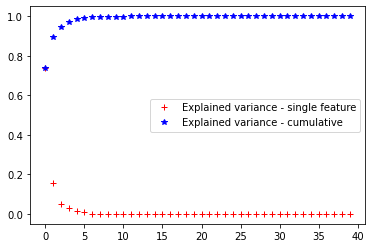

In [36]:
%%time
N_PCA=40
p = PCA(n_components=N_PCA).fit(X_to_reduce)
ns = list(range(N_PCA))

plt.figure()
plt.plot(ns, [ p.explained_variance_ratio_[n] for n in ns], 
         'r+', label="Explained variance - single feature")
plt.plot(ns, [ p.explained_variance_ratio_.cumsum()[n] for n in ns], 
         'b*', label="Explained variance - cumulative")
_ = plt.legend()


In [56]:
pca50 = PCA(n_components = 50)
X_reduced = pca50.fit_transform(X_to_reduce)

In [57]:
df_reduced = pd.DataFrame(X_reduced)
df_reduced

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-297.545486,72.935606,15.220546,2.680500,16.687012,-0.973792,7.515218,11.287338,6.939310,-28.672172,...,1.994613,-2.878028,-2.289939,-1.124398,-0.537171,1.822257,-3.161360,1.006603,-0.324394,-1.906104
1,-297.537496,72.987396,15.313183,2.845524,15.434343,-1.342194,7.792448,11.316733,7.205318,-29.283738,...,2.683963,-3.598601,-1.519076,-1.106486,-0.371789,1.716517,-2.596337,0.832839,-0.590665,-2.755947
2,-298.907014,68.892921,7.879666,-9.719862,88.780826,16.146196,23.339601,4.772889,11.314403,-9.295850,...,-1.333776,0.803290,3.365719,-0.205314,-0.736533,1.127524,1.658475,-0.293826,-0.971046,-1.869450
3,-326.140594,20.187487,-32.699240,-45.773255,213.358555,49.091522,-42.042402,-3.025443,16.949185,20.462931,...,-0.988772,0.485816,1.574528,-0.245908,-0.877682,1.297084,0.149258,-1.729056,-0.342548,1.249686
4,-78.537496,-66.364641,51.562655,12.993161,98.965031,67.746233,36.313448,17.694191,-53.698748,14.487776,...,-0.382955,1.185159,1.396479,1.299536,1.444807,-2.364372,1.336561,0.182322,-1.028355,-2.212168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16065,-302.443423,60.643478,-9.393265,-36.238774,97.173571,38.906783,19.587164,2.342164,11.556710,13.059468,...,0.609879,0.551645,-2.527457,0.530952,0.536972,-1.336144,0.576891,-0.607315,0.471821,1.713887
16066,194.643050,82.977317,-184.629105,57.475740,120.963506,36.118978,13.117549,15.184232,-26.788367,15.436581,...,1.251967,-0.449861,-2.872662,0.603216,0.833208,-0.752514,-0.808431,-2.070672,-0.252060,0.038863
16067,-320.843725,37.114062,-5.047384,-1.704369,-152.107224,-62.821520,-31.729101,-17.035192,15.900588,15.121485,...,-7.173551,-3.137851,-1.519087,2.023393,-0.898186,1.546708,1.624497,1.445644,-0.537007,-0.722824
16068,193.790474,80.872721,-188.395318,49.878258,144.441115,32.712876,8.920838,1.470768,-34.631523,22.267755,...,1.006382,-2.576256,-2.478103,-1.724657,-2.501389,1.696403,0.706058,-0.702595,-0.225661,0.073029


In [58]:
df_reduced['En'] = data_en[:ind]

In [59]:
df_reduced

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,En
0,-297.545486,72.935606,15.220546,2.680500,16.687012,-0.973792,7.515218,11.287338,6.939310,-28.672172,...,-2.878028,-2.289939,-1.124398,-0.537171,1.822257,-3.161360,1.006603,-0.324394,-1.906104,37.8010
1,-297.537496,72.987396,15.313183,2.845524,15.434343,-1.342194,7.792448,11.316733,7.205318,-29.283738,...,-3.598601,-1.519076,-1.106486,-0.371789,1.716517,-2.596337,0.832839,-0.590665,-2.755947,44.1107
2,-298.907014,68.892921,7.879666,-9.719862,88.780826,16.146196,23.339601,4.772889,11.314403,-9.295850,...,0.803290,3.365719,-0.205314,-0.736533,1.127524,1.658475,-0.293826,-0.971046,-1.869450,19.4085
3,-326.140594,20.187487,-32.699240,-45.773255,213.358555,49.091522,-42.042402,-3.025443,16.949185,20.462931,...,0.485816,1.574528,-0.245908,-0.877682,1.297084,0.149258,-1.729056,-0.342548,1.249686,-0.1086
4,-78.537496,-66.364641,51.562655,12.993161,98.965031,67.746233,36.313448,17.694191,-53.698748,14.487776,...,1.185159,1.396479,1.299536,1.444807,-2.364372,1.336561,0.182322,-1.028355,-2.212168,-23.8799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16065,-302.443423,60.643478,-9.393265,-36.238774,97.173571,38.906783,19.587164,2.342164,11.556710,13.059468,...,0.551645,-2.527457,0.530952,0.536972,-1.336144,0.576891,-0.607315,0.471821,1.713887,30.1280
16066,194.643050,82.977317,-184.629105,57.475740,120.963506,36.118978,13.117549,15.184232,-26.788367,15.436581,...,-0.449861,-2.872662,0.603216,0.833208,-0.752514,-0.808431,-2.070672,-0.252060,0.038863,6.8265
16067,-320.843725,37.114062,-5.047384,-1.704369,-152.107224,-62.821520,-31.729101,-17.035192,15.900588,15.121485,...,-3.137851,-1.519087,2.023393,-0.898186,1.546708,1.624497,1.445644,-0.537007,-0.722824,67.1569
16068,193.790474,80.872721,-188.395318,49.878258,144.441115,32.712876,8.920838,1.470768,-34.631523,22.267755,...,-2.576256,-2.478103,-1.724657,-2.501389,1.696403,0.706058,-0.702595,-0.225661,0.073029,8.0652


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop('En', axis = 1), df['En'], test_size=0.3, random_state=42)

In [61]:
%%time
ridge = Ridge()
params_ridge = {'alpha': [1.0, 0.5, 3.0]}
ridge_grid = GridSearchCV(ridge, params_ridge)
ridge_grid.fit(X_train, y_train)

Wall time: 217 ms


GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1.0, 0.5, 3.0]})

In [62]:
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

{'alpha': 3.0}
0.7336399659064828


In [63]:
%%time
lasso = Lasso(max_iter = 2000)
params_lasso = {'alpha': [1.0, 0.5, 3.0]}
lasso_grid = GridSearchCV(lasso, params_lasso)
lasso_grid.fit(X_train, y_train)

Wall time: 412 ms


GridSearchCV(estimator=Lasso(max_iter=2000),
             param_grid={'alpha': [1.0, 0.5, 3.0]})

In [64]:
print(lasso_grid.best_params_)
print(lasso_grid.best_score_)

{'alpha': 0.5}
0.733763338070775


In [65]:
%%time
rand_forest_regr = RandomForestRegressor(max_depth = 30)
rand_forest_regr.fit(X_train, y_train)

Wall time: 39.2 s


RandomForestRegressor(max_depth=30)

In [66]:
rand_forest_regr.score(X_test, y_test)

0.8206153078127382

In [67]:
%%time
knn_regr = KNeighborsRegressor()
params_knn = {'n_neighbors': [2, 5, 12, 25, 33]}
knn_grid = GridSearchCV(knn_regr, params_knn, verbose = 1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 6.27 s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.1s finished


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 5, 12, 25, 33]}, verbose=1)

In [68]:
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'n_neighbors': 5}
0.7503579055098994


In [69]:
%%time
elastic = ElasticNet(max_iter = 4000)
params_elastic = {'alpha': [1,3], 'l1_ratio': [0.5, 0.25, 0.75]}
elastic_grid = GridSearchCV(elastic, params_elastic, verbose = 1)
elastic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 876 ms


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


GridSearchCV(estimator=ElasticNet(max_iter=4000),
             param_grid={'alpha': [1, 3], 'l1_ratio': [0.5, 0.25, 0.75]},
             verbose=1)

In [70]:
print(elastic_grid.best_params_)
print(elastic_grid.best_score_)

{'alpha': 1, 'l1_ratio': 0.25}
0.7334756546032019


In [71]:
%%time
xgb_model.fit(X_train, y_train)

Wall time: 5.25 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [72]:
predict = xgb_model.predict(X_test)
mean_squared_error(y_test, predict)

142.93742479795873